#### VALIDATING DSSD on the [Emotions dataset](http://sourceforge.net/projects/mulan/files/datasets/emotions.rar)

This notebook is used to assess the correctness/conformity of the DSSD algorithm.
We proceed by running the same experiments on the Emotions dataset described in the research paper using the authors implementation and ours.

We compute the similarity percentage between our results and the the authors.

If desired, we can replicate this approach on other datasets as well. 

{'cover': {'ours': 100, 'theirs': 100, 'diff_count': 22, 'similarity': 78.0}, 'cover_var': {'ours': 15, 'theirs': 15, 'diff_count': 1, 'similarity': 93.33333333333333}, 'desc': {'ours': 100, 'theirs': 100, 'diff_count': 6, 'similarity': 94.0}, 'desc_var': {'ours': 71, 'theirs': 72, 'diff_count': 11, 'similarity': 84.72222222222223}, 'average_similary%': 87.51388888888889}


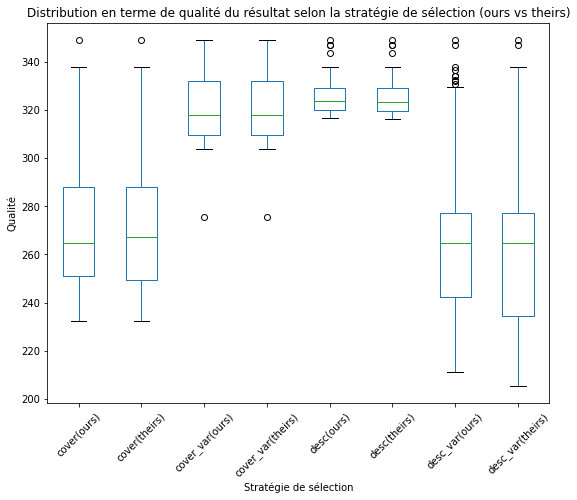

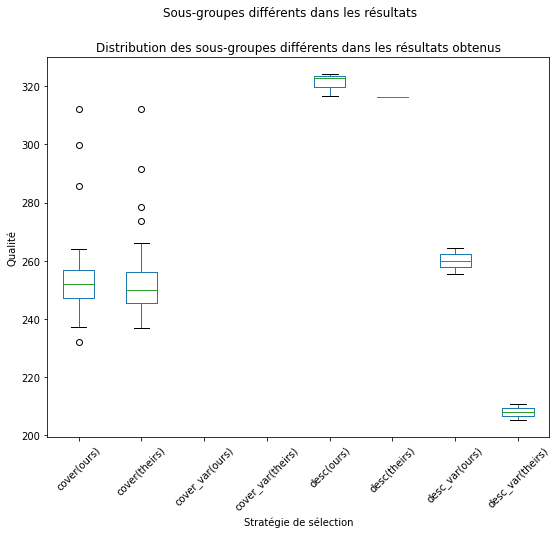

In [2]:
import pandas as pd
from skmine.dssd import Cond
from skmine.dssd.utils import diff_items_count

# loading results of the implementation used in the base article
# In order to have these results, one needs to download the binary and run it on the desired dataset, and then fill here the paths of the results for the different selection strategies
their_base_folder = "..."
their_df_desc = pd.read_csv(f"{their_base_folder}/xps/dssd/emotions-1655804995-description-max_depth=3/stats3-1655804995.csv", sep = ";")
their_df_desc_var = pd.read_csv(f"{their_base_folder}/xps/dssd/emotions-1655805902-descriptionvar-2-max_depth=3/stats3-1655805902.csv", sep = ";")
their_df_cover = pd.read_csv(f"{their_base_folder}/xps/dssd/emotions-1655805357-cover-max_depth=3/stats3-1655805357.csv", sep = ";")
their_df_cover_var = pd.read_csv(f"{their_base_folder}/xps/dssd/emotions-1655806928-covervar-0.5-max_depth=3/stats3-1655806928.csv", sep = ";")


# loading in our results
our_base_folder = "..."
our_df_desc = pd.read_pickle(f"{our_base_folder}/desc[min_diff_conditions=2]/stats3-final-results.dat")
our_df_desc_var = pd.read_pickle(f"{our_base_folder}/var_desc[max_attribute_occ=2]/stats3-final-results.dat")
our_df_cover = pd.read_pickle(f"{our_base_folder}/cover[weight=0.9]/stats3-final-results.dat")
our_df_cover_var = pd.read_pickle(f"{our_base_folder}/var_cover[weight=0.9-fraction=0.5]/stats3-final-results.dat")


# as the results from the official implementation are only provided as csv files, we load them in correctly and apply some convertions in order to ease deling with these results
def fix_their_description(df: pd.DataFrame):
    df["description"] = df["description"].str.replace("[\(\)]", "")
    df["description"] = df["description"].apply(lambda x: [s for s in x.strip().replace(" ", " ").split("&&") if len(s) > 0])
    df["description"] = df["description"].apply(lambda x: [list(filter(lambda x: len(x) > 0, cond.split(" "))) for cond in x])
    df["description"] = df["description"].apply(lambda x: [Cond(x[0], x[1], float(x[2])) for x in x])
    df["description"] = df["description"].apply(lambda x: tuple(set(x)))

# we do the same thing here but later if the results from our experiments are provided differently, we should just update this function
def fix_our_description(df: pd.DataFrame):
    df["pattern"] = df["pattern"].apply(lambda desc: [Cond(cond.attribute, cond.op, round(float(cond.val), 5)) for cond in desc.conditions])
    df["pattern"] = df["pattern"].apply(lambda x: tuple(set(x)))
    df.rename(inplace=True, columns = {"pattern": "description"})
 

# actually fixing the description of both results
their_dfs = [their_df_cover, their_df_cover_var, their_df_desc, their_df_desc_var]
for their_df in their_dfs: fix_their_description(their_df)

our_dfs = [our_df_cover, our_df_cover_var, our_df_desc, our_df_desc_var]
for our_df in our_dfs: fix_our_description(our_df)

methods = ["cover", "cover_var", "desc", "desc_var"]
diff_counts = {}

our_df_qualities, their_df_qualities, df_qualities = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
our_df_diff_qualities, their_df_diff_qualities, full_df_diff_qualities = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()


# this function return the qualities of subgroups that differ in our results and the official ones
def diff_qualities(df_source, df_dest):
    return df_source[~(df_source["description"].isin(df_dest["description"]))]["quality"]

for our_df, their_df, method_name in zip(our_dfs, their_dfs, methods):
    # we assume that two subgroups are the same if they have the exact description
    diff_count = diff_items_count(list(our_df["description"].values.ravel()), list(their_df["description"].values.ravel()))
    our_length = len(our_df["description"].values)
    their_length = len(their_df["description"].values)
    max_length = max(our_length, their_length)
    diff_counts[method_name] = { "ours": our_length, "theirs": their_length, "diff_count": diff_count, "similarity": 100 * (max_length - diff_count) / (max_length) }

    # aggregate the quality columns from all the different selection strategies into a single df for easier plotting later
    our_df_qualities[method_name] = our_df["quality"]
    their_df_qualities[method_name] = their_df["quality"]

    # qualities of subgroups that were in our result but not in the official one
    our_df_diff_qualities[method_name] = diff_qualities(our_df, their_df)
    # inverse 
    their_df_diff_qualities[method_name] = diff_qualities(their_df, our_df)

# computing the average similary in the results for the considered selection strategies
diff_counts["average_similary%"] = sum(d["similarity"] for d in diff_counts.values()) / len(diff_counts)

print(diff_counts)

full_df_qualities = pd.concat([
 our_df_qualities.rename(lambda x: f"{x}(ours)", axis="columns"),
 their_df_qualities.rename(lambda x: f"{x}(theirs)", axis="columns")
], sort=True)

full_df_diff_qualities = pd.concat([
 our_df_diff_qualities.rename(lambda x: f"{x}(ours)", axis="columns"),
 their_df_diff_qualities.rename(lambda x: f"{x}(theirs)", axis="columns")
], sort=True)


import matplotlib.pyplot as plt
full_df_qualities.boxplot(figsize=(9, 7),rot=45, grid=False)
plt.title("Distribution en terme de qualité du résultat selon la stratégie de sélection (ours vs theirs)")
plt.ylabel("Qualité")
plt.xlabel("Stratégie de sélection")
plt.show()


full_df_diff_qualities.boxplot(figsize=(9, 7),rot=45, grid=False)
plt.title("Distribution des sous-groupes différents dans les résultats obtenus")
plt.ylabel("Qualité")
plt.suptitle("Sous-groupes différents dans les résultats")
plt.xlabel("Stratégie de sélection")
plt.show()